1. DAU/WAU/MAU를 line chart로 시각화 **(완료)**
2. 유저별 평균접속시간의 분포를 ECDF로 시각화
3. 방문 주차에 따른 코호트를 생성하고, 코호트 별로 weekly 리텐션을 구하고 이를 heatmap으로 시각화
4. 요일/시간대별 사용자 수를 구하고 이를 heatmap으로 시각화

문제:  방문 주차에 따른 코호트를 생성하고, 코호트 별로 weekly 리텐션을 구하고 이를 heatmap으로 시각화
코호트: 같은 시기에 가입한 사람들 -> 주기 1주일

1. 전처리
- 필요 데이터: date, fullVisitorId
- 불필요 데이터 -> 삭제: sessionId,	socialEngagementType, visitId,visitNumber
- 날짜 전처리: date

In [46]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime as dt
import matplotlib.font_manager as fm

In [47]:
df0 = pd.read_csv('/Users/t2023-m0017/Desktop/[파이썬]/ML/심화프로젝트/GA4데이터/train.csv')

/var/folders/1y/dmb1rjqn7y7ft_t08s501gxm0000gn/T/ipykernel_20108/3133144623.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv('/Users/t2023-m0017/Desktop/[파이썬]/ML/심화프로젝트/GA4데이터/train.csv')


In [85]:
df = df0.copy()

In [86]:
# 전처리
# 불필요 삭제
df = df.drop([ 'sessionId','socialEngagementType', 'visitId','visitNumber'], axis=1)
# 날짜화
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')
df.dtypes

In [149]:
# 목적: 월-주(주의 첫 날짜)별 방문ID집계
# 방법: date를 W-MON(첫날짜)로 변경하여 각 날짜의 fullVisitorId의 고유값 수량 집계
df['date_week'] = df['date'].dt.strftime('%Y-%U')
df.head()

#실패한 방법들
#df_co = df.groupby([pd.Grouper(key='date', freq='W-MON')])['fullVisitorId'].nunique().reset_index()
#df.set_index(df['date'], inplace=True)
# df['date_week'] = df['date'].dt.strftime("%m-w%")
#df['date_week1'] = df['date'].dt.isocalendar().week
# a = df.groupby([pd.Grouper(key='date', freq='W-MON')])['fullVisitorId'].nunique()
# df.resample('W-MON')

,channelGrouping,date,device,fullVisitorId,geoNetwork,totals,trafficSource,visitStartTime,date_week,first_visit
0,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,2016-35,2016-35
1,Organic Search,2016-09-02,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,2016-35,2016-35
2,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,2016-35,2016-35
3,Organic Search,2016-09-02,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,2016-35,2016-35
4,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2016-35,2016-32


In [104]:
# 방문 주차에 따른 코호트에 필요한 컬럼: 고객ID,방문날짜, 첫 방문날짜
# 첫방문= 가입주차 계산, (date_week)고객별 첫 방문주 구하기
# transform()를 통해 저장

df['first_visit'] = df.groupby('fullVisitorId')['date_week'].transform('min')
df_co = df[['fullVisitorId','date_week','first_visit']]
df_co

,fullVisitorId,date_week,first_visit
0,1131660440785968503,2016-35,2016-35
1,377306020877927890,2016-35,2016-35
2,3895546263509774583,2016-35,2016-35
3,4763447161404445595,2016-35,2016-35
4,27294437909732085,2016-35,2016-32
...,...,...,...
903648,5123779100307500332,2017-01,2017-01
903649,7231728964973959842,2017-01,2017-01
903650,5744576632396406899,2017-01,2017-01
903651,2709355455991750775,2017-01,2017-01


In [105]:
print(df_co.describe())
print(df_co.info())

             fullVisitorId date_week first_visit
count               903653    903653      903653
unique              742735        53          53
top     824839726118485274   2016-48     2016-46
freq                   205     27930       27758
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fullVisitorId  903653 non-null  object
 1   date_week      903653 non-null  object
 2   first_visit    903653 non-null  object
dtypes: object(3)
memory usage: 20.7+ MB
None


In [106]:
# 목적: 코호트 분석을 위해 frist_visit별 (재)방문날짜의 방문수
# 방법: unstack() 매서드-> 데이터를 재 구조화한다(가로로)
cohort = df_co.groupby(['first_visit', 'date_week'])['fullVisitorId'].nunique().unstack()
cohort.head(10)

date_week,2016-31,2016-32,2016-33,2016-34,2016-35,2016-36,2016-37,2016-38,2016-39,2016-40,...,2017-22,2017-23,2017-24,2017-25,2017-26,2017-27,2017-28,2017-29,2017-30,2017-31
first_visit,,,,,,,,,,,,,,,,,,,,,
2016-31,12726.0,467.0,361.0,259.0,188.0,147.0,165.0,126.0,115.0,127.0,...,9.0,11.0,10.0,9.0,11.0,9.0,8.0,11.0,14.0,3.0
2016-32,NaN,14612.0,334.0,226.0,186.0,128.0,114.0,97.0,73.0,70.0,...,6.0,5.0,3.0,6.0,3.0,1.0,6.0,1.0,3.0,3.0
2016-33,NaN,NaN,14467.0,498.0,200.0,150.0,180.0,118.0,88.0,93.0,...,4.0,7.0,6.0,9.0,4.0,5.0,12.0,4.0,5.0,1.0
2016-34,NaN,NaN,NaN,13469.0,295.0,136.0,136.0,122.0,79.0,98.0,...,3.0,4.0,3.0,6.0,2.0,3.0,2.0,5.0,2.0,NaN
2016-35,NaN,NaN,NaN,NaN,14719.0,314.0,144.0,129.0,111.0,90.0,...,5.0,4.0,5.0,4.0,1.0,5.0,3.0,6.0,2.0,3.0
2016-36,NaN,NaN,NaN,NaN,NaN,13406.0,290.0,129.0,106.0,136.0,...,3.0,3.0,1.0,3.0,NaN,3.0,1.0,4.0,1.0,1.0
2016-37,NaN,NaN,NaN,NaN,NaN,NaN,13784.0,360.0,201.0,199.0,...,5.0,7.0,6.0,1.0,3.0,2.0,3.0,4.0,6.0,4.0
2016-38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13825.0,286.0,237.0,...,1.0,3.0,4.0,1.0,1.0,5.0,4.0,4.0,3.0,1.0
2016-39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13525.0,329.0,...,3.0,5.0,3.0,3.0,5.0,3.0,4.0,2.0,4.0,NaN


In [11]:
# 비고 :unstack() 매서드 차이(세로로 길다)
cohort_1 = df_co.groupby(['first_visit', 'date_week'])['fullVisitorId'].nunique()
cohort_1.head(3)

first_visit  date_week
1            1            12299
             2              269
             3              300
Name: fullVisitorId, dtype: int64

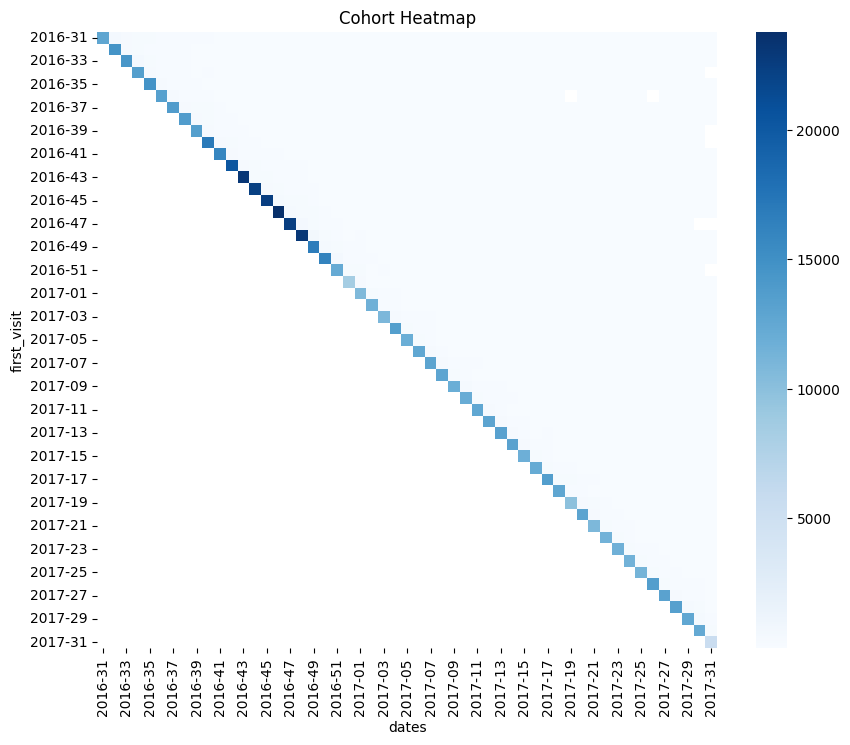

In [107]:
# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cohort, annot=False, cmap='Blues')
plt.title('all visit Cohort Heatmap')
plt.xlabel('dates')
plt.ylabel('first_visit')
plt.show()

해석
1. 첫방문자가 대부분이고 재 방문자의 수가 적어서 색이 희미하다
2. 첫 방문주에서 41주-43주 사이에 방문이 증가했다

대안: 재 방문고객만으로 코호트를 분석한다면?


In [122]:
df_co2 = df_co.copy()

In [125]:
# 목적: 2회 이상 방문한 사람들의 코호트
# 2회 이상 방문한 고객 -> 87075명
# 방법: df_co2컬럼에서 fullVisitorId의 수량 집계
cond = df_co2.groupby('fullVisitorId').count()
# cond = 집계된 수량이 1 초과한 조건 fullVisitorId(cond의 인덱스가 fullVisitorId)
cond = cond[cond['date_week']>1]
cond = cond.index
cond

Index([       40862739425590,        64767209884626,       109798218040435,
             113091074918758,       120513263852408,       166465265517759,
             166529102473253,       170187170673177,       221538522301438,
             231955209315461,
       ...
       '9990183617359422098', '9990353749211091326', '9990725071484202506',
        '999203594099745000', '9992389773298540122', '9993204973689965101',
       '9995936593177786964', '9996299359396130241',  '999889763383834152',
       '9999355589118867468'],
      dtype='object', name='fullVisitorId', length=87075)

In [126]:
# 의미: 2번이상방문한 87075명의 고객이  247993회 방문함
df_co2 = df_co2[df_co2['fullVisitorId'].isin(cond)]
df_co2 

,fullVisitorId,date_week,first_visit
4,27294437909732085,2016-35,2016-32
16,9876750586615598787,2016-35,2016-35
44,0715569826025005549,2016-35,2016-35
46,7356002680834488802,2016-35,2016-35
47,3523749053085989464,2016-35,2016-35
...,...,...,...
903634,3591531861629139100,2017-01,2017-01
903639,168043908052904808,2017-01,2017-01
903644,256641390199759052,2017-01,2017-01
903651,2709355455991750775,2017-01,2017-01


In [128]:
# 2회 이상 방문한 고객 수 확인
df_co2['fullVisitorId'].nunique()

87075

In [134]:
cohort2 = df_co2.groupby(['first_visit', 'date_week'])['fullVisitorId'].nunique().unstack()
cohort2.head(3)

date_week,2016-31,2016-32,2016-33,2016-34,2016-35,2016-36,2016-37,2016-38,2016-39,2016-40,...,2017-22,2017-23,2017-24,2017-25,2017-26,2017-27,2017-28,2017-29,2017-30,2017-31
first_visit,,,,,,,,,,,,,,,,,,,,,
2016-31,2010.0,467.0,361.0,259.0,188.0,147.0,165.0,126.0,115.0,127.0,...,9.0,11.0,10.0,9.0,11.0,9.0,8.0,11.0,14.0,3.0
2016-32,NaN,1940.0,334.0,226.0,186.0,128.0,114.0,97.0,73.0,70.0,...,6.0,5.0,3.0,6.0,3.0,1.0,6.0,1.0,3.0,3.0
2016-33,NaN,NaN,2074.0,498.0,200.0,150.0,180.0,118.0,88.0,93.0,...,4.0,7.0,6.0,9.0,4.0,5.0,12.0,4.0,5.0,1.0


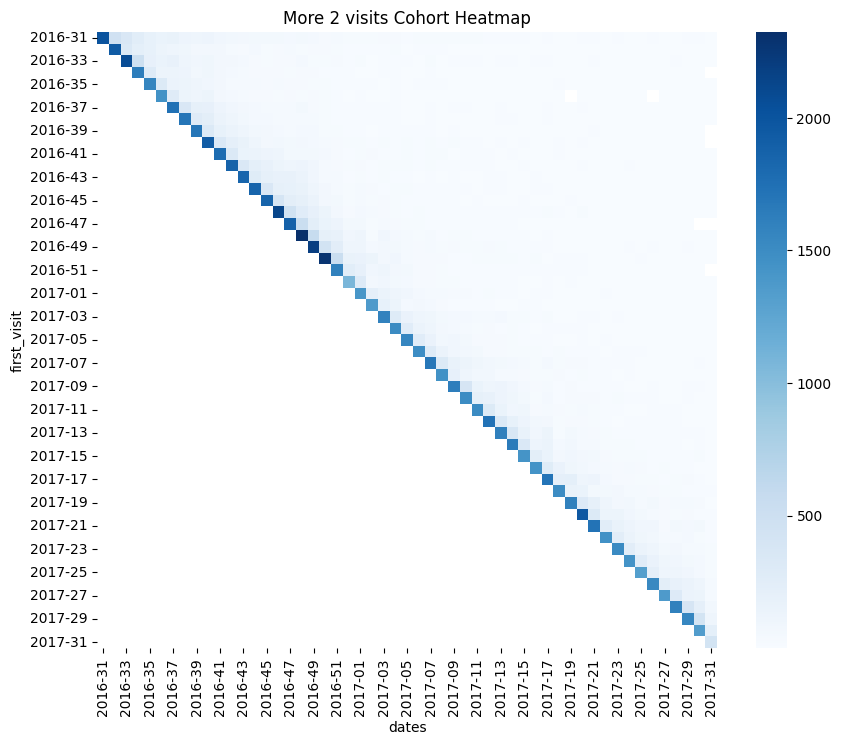

In [150]:
# 2회 이상 방문한 고객의 코호트 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cohort2, annot=False, cmap='Blues')
plt.title('More 2 visits Cohort Heatmap')
plt.xlabel('dates')
plt.ylabel('first_visit')
plt.show()

실 구매자의 코호트

방법
1. 실 구매자의 id구하기
2. df_co에서 실 구매자의 id가 포함된 코호트 데이터 추출
3. 시각화

In [143]:
# https://www.kaggle.com/code/matthuan/ga-analysis에서 참고한 컬럼꺼내기, 기존 fulvisitorid와 totals컬럼들을 함께 보기 위함

json_columns = ['totals']
from pandas import json_normalize

def load_dataframe(csv_path):
    path = csv_path
    df = pd.read_csv(path, converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'})
   
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

train = load_dataframe('/Users/t2023-m0017/Desktop/[파이썬]/ML/심화프로젝트/GA4데이터/train.csv')


In [152]:
# 목적: 구입한 경험이 있는 fullVisitorId 구하기 -> 11515의 구매건의 id
# 방법: 결측치 제거
train1 = train.copy()
df2 = train1[['fullVisitorId','totals_transactionRevenue']]
df2 = df2.dropna(how = 'any')
df2.info()
print(df2['fullVisitorId'].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 11515 entries, 752 to 903317
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   fullVisitorId              11515 non-null  object
 1   totals_transactionRevenue  11515 non-null  object
dtypes: object(2)
memory usage: 269.9+ KB
9996


In [178]:
# df_co3 = 실구매자의 코호트
# cond2 = 실 구매자의 id
# 실 구매 주문  -> 9996명이 11515주문건
# 실구매한 fullVisitorId의 고유값
### 왜 11515개의 행이 아니라 7천개로 줄어들었지?

df_co3 = df_co.copy()
cond2 = list(df2['fullVisitorId'])
# cond2 = pd.DataFrame(cond2)
df_co4 = df_co3[df_co3['fullVisitorId'].isin(cond2)]
print(df_co3.info())
print(df_co4.info())
# cohort_3 = df_co3.groupby(['first_visit', 'date_week'])['fullVisitorId'].nunique().unstack()
#df2['fullVisitorId'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fullVisitorId  903653 non-null  object
 1   date_week      903653 non-null  object
 2   first_visit    903653 non-null  object
dtypes: object(3)
memory usage: 20.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7936 entries, 153 to 524137
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fullVisitorId  7936 non-null   object
 1   date_week      7936 non-null   object
 2   first_visit    7936 non-null   object
dtypes: object(3)
memory usage: 248.0+ KB
None


In [24]:
# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cohort_3, annot=False, cmap='Blues')
plt.title('Cohort Heatmap')
plt.xlabel('dates')
plt.ylabel('first_visit')
plt.show()

NameError: name 'cohort_3' is not defined

<Figure size 1000x800 with 0 Axes>